[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/niconoe/pyinaturalist/main?filepath=examples%2FData%2520Visualizations%2520-%2520Regional%2520Activity%2520Report.ipynb)

# Regional activity time series visualizations
This example shows how to create visualizations of iNaturalist activity over time in a given region.
See https://www.inaturalist.org/places to find place IDs.

Visualization are made using [Altair](https://altair-viz.github.io), with the following metrics:
* Number of observations
* Number of taxa observed
* Number of observers
* Number of identifiers

In [ ]:
from datetime import datetime
from time import sleep
from typing import Any, BinaryIO, Dict, Iterable, List, Optional, Tuple

import altair as alt
import pandas as pd
from pyinaturalist import (
    ICONIC_TAXA,
    get_interval_ranges,
    get_observation_histogram,
    get_observation_identifiers,
    get_observation_observers,
    get_observation_species_counts,
    get_observations,
)

# Adjustable values
PLACE_ID = 6
PLACE_NAME = 'Alaska'
YEAR = 2020

### Observations per year
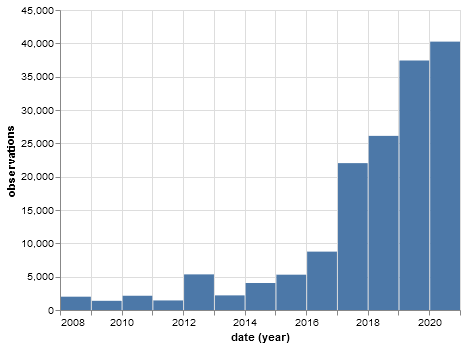

In [ ]:
observations_by_year = get_observation_histogram(
    place_id=PLACE_ID,
    interval='year',
    d1='2008-01-01',
    d2=f'{YEAR}-12-31',
    verifiable=True,
)
observations_by_year = pd.DataFrame(
    [{'date': k, 'observations': v} for k, v in observations_by_year.items()]
)

alt.Chart(observations_by_year).mark_bar().encode(x='year(date):T', y='observations:Q')

### Observations per month
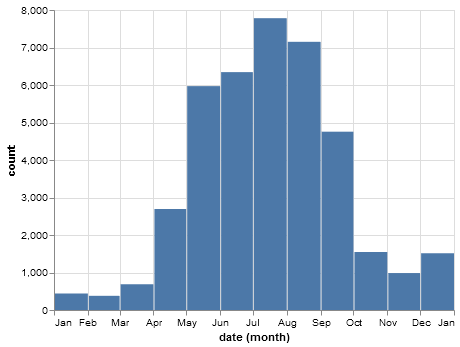

In [ ]:
observations_by_month = get_observation_histogram(
    place_id=PLACE_ID,
    interval='month',
    d1='2020-01-02',
    d2='2020-12-31',
    verifiable=True,
)
observations_by_month = pd.DataFrame(
    [{'metric': 'Observations', 'date': k, 'count': v} for k, v in observations_by_month.items()]
)
alt.Chart(observations_by_month).mark_bar().encode(x='month(date):T', y='count:Q')

### Histograms with custom metrics
The API does not have a histogram endpoint for taxa observed, observers, or identifiers,
so we first need to determine our date ranges of interest, and then run one search per date range.

Here are a couple helper functions to make this easier:

In [ ]:
def count_date_range_results(function, start_date, end_date):
    """Get the count of results for the given date range and search function"""
    # Running this search with per_page=0 will (quickly) return only a count of results, not complete results
    response = function(
        place_id=PLACE_ID,
        d1=start_date,
        d2=end_date,
        verifiable=True,
        per_page=0,
    )
    print(f'Total results for {start_date.strftime("%b")}: {response["total_results"]}')
    return response['total_results']


def get_monthly_counts(function, label):
    """Get the count of results per month for the given search function"""
    month_ranges = get_interval_ranges(datetime(YEAR, 1, 1), datetime(YEAR, 12, 31), 'month')
    counts_by_month = {
        start_date: count_date_range_results(function, start_date, end_date)
        for (start_date, end_date) in month_ranges
    }
    return pd.DataFrame(
        [{'metric': label, 'date': k, 'count': v} for k, v in counts_by_month.items()]
    )

### Unique taxa observed per month
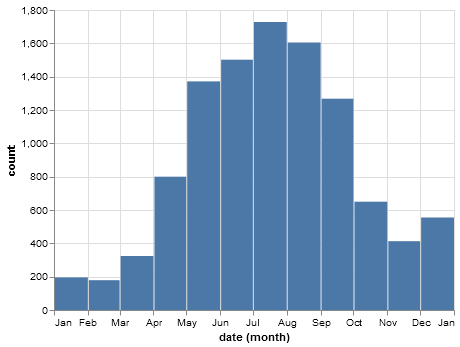

In [ ]:
taxa_by_month = get_monthly_counts(get_observation_species_counts, 'Taxa')
alt.Chart(taxa_by_month).mark_bar().encode(x='month(date):T', y='count:Q')

### Observers per month
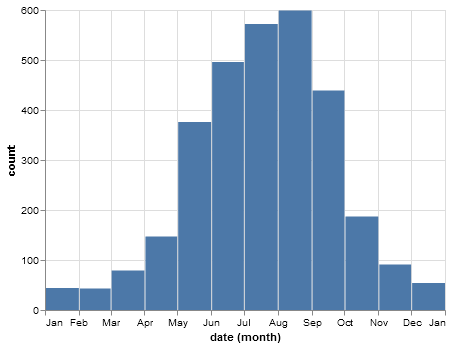

In [ ]:
observers_by_month = get_monthly_counts(get_observation_observers, 'Observers')
alt.Chart(observers_by_month).mark_bar().encode(x='month(date):T', y='count:Q')

### Identifiers per month
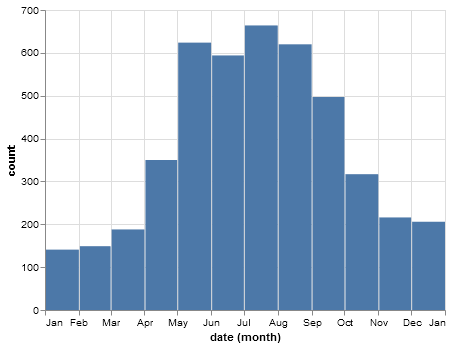

In [ ]:
identifiers_by_month = get_monthly_counts(get_observation_identifiers, 'Identifiers')
alt.Chart(identifiers_by_month).mark_bar().encode(x='month(date):T', y='count:Q')

### Combine all monthly metrics into one plot
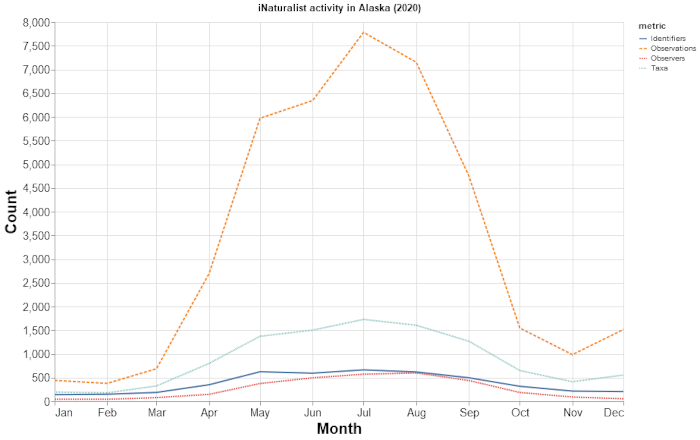

In [ ]:
combined_results = observations_by_month.append(
    [taxa_by_month, observers_by_month, identifiers_by_month]
)

alt.Chart(
    combined_results,
    title=f'iNaturalist activity in {PLACE_NAME} ({YEAR})',
    width=750,
    height=500,
).mark_line().encode(
    alt.X('month(date):T', axis=alt.Axis(title="Month")),
    alt.Y('count:Q', axis=alt.Axis(title="Count")),
    color='metric',
    strokeDash='metric',
).configure_axis(
    labelFontSize=15,
    titleFontSize=20,
)